In [1]:
import evaluation
from CA_model import CA_model
import topography
import matplotlib.pyplot as plt
import Iceing_model
import numpy as np
from skimage.transform import resize
from scipy.stats import wilcoxon

In this notebook we conduct the experiments:

1. call the Ising model and generate the reference data
2. initialize the CA model and generate data with it
3. build the inflection distributions
4. non-parametric t-test for difference in mean

In [3]:
# set the size
size = 500

## 1. Baseline Ising model

In [4]:
# initialize the Ising model
iceing_test = Iceing_model.iceing_model(0.45, size)

# run it until convergence
ponds, sums = iceing_test.run(15_000_000)

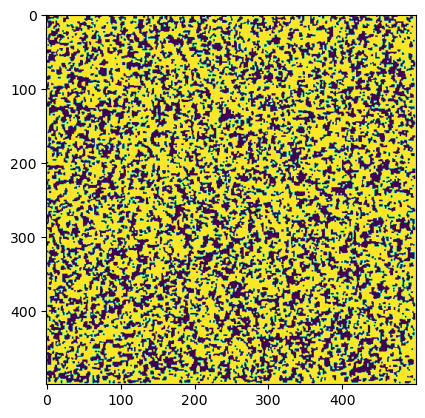

In [5]:
plt.imshow(ponds)

## 2. CA model

In [6]:
# initialize model with real world like 'snow dune topography' Popovic et al., 2020

res = size                      # size of the domain
mode = 'snow_dune'              # topography type
tmax = 2; dt = 0.1              # diffusion time and time-step if mode = 'diffusion' or mode = 'rayleigh'
g = 1                           # anisotropy parameter
sigma_h = 0.03                  # surface standard deviation
snow_dune_radius = 1.           # mean snow dune radius if mode = 'snow_dune'  
Gaussians_per_pixel = 0.2       # density of snow dunes if mode = 'snow_dune'  
snow_dune_height_exponent = 1.  # exponent that relates snow dune radius and snow dune height if mode = 'snow_dune'

mean_freeboard = 0.1

Tdrain = 10.; dt_drain = 0.5    # time and time-step of to drainage

# create topography
dist_ca = topography.Create_Initial_Topography(res = res, mode = mode, tmax = tmax, dt = dt, g = g, sigma_h = sigma_h, h = mean_freeboard, snow_dune_radius = snow_dune_radius,
            Gaussians_per_pixel = Gaussians_per_pixel, number_of_r_bins = 150, window_size = 5, snow_dune_height_exponent = snow_dune_height_exponent)


/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
# initialize model without surface water
h = np.zeros(shape = (size, size))
ca_model = CA_model(dist_ca, h, dt = 15, dx = 1, periodic_bounds= True, enhanced_melt_rate= True, horizontal_flux= True, ice_melting= True, seepage= True)

In [8]:
# Run the model for 25000 time steps (4 days 8 hours)
# h, H, Ht = ca_model.run(25_000)

In [9]:
# save the data
# np.save('experiment_data/h_snow_dune_500px_25000iter_ice_melt_False.npy', h)

In [10]:
# load the data instead of waiting for model
h = np.load('experiment_data/h_snow_dune_500px_25000iter_ice_melt_False.npy')

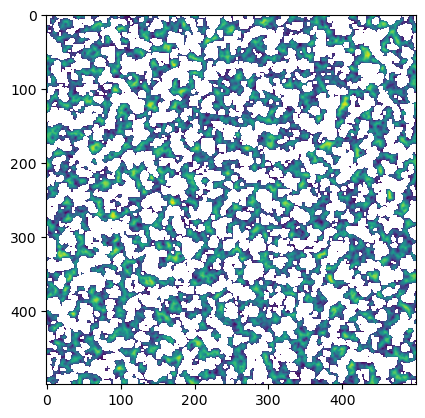

In [11]:
thresh = 0.02 # set min surface water depth for pond
plt.imshow(np.ma.masked_where(h<thresh,h))

# 3. build inflection distributions

In [12]:
# build inflection distribution for Ising
inflections_ising = evaluation.inflection_list(ponds)

In [13]:
# get inflection points for CA
inflections_ca = evaluation.inflection_list(np.where(h<thresh, 1, -1))

Text(0, 0.5, 'inflection point')

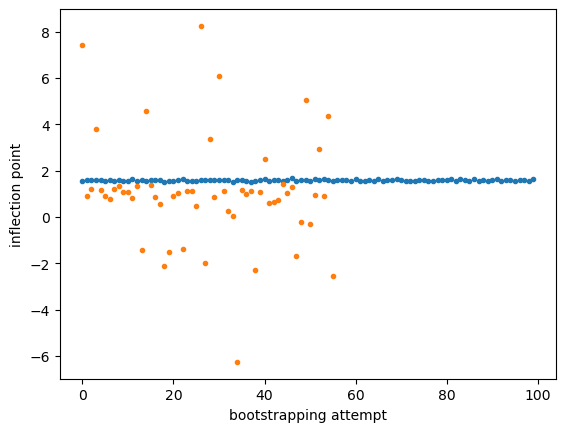

In [14]:
# plot
plt.plot(inflections_ising, ls = '', marker = '.')
plt.plot(inflections_ca, ls = '', marker = '.')
plt.xlabel('bootstrapping attempt')
plt.ylabel('inflection point')

## 4. Compare inflection distributions with ttest

In [15]:
wilcoxon(inflections_ising[:len(inflections_ca)], inflections_ca[:len(inflections_ising)])

WilcoxonResult(statistic=441.0, pvalue=0.003590316543175898)